# Implementing a toy denoiser from scratch 

Implementing a toy denoiser for the MNIST dataset from scratch. 
The denoiser is trained on the MNIST dataset with added noise. 

(1) Get and prepare the data for training / validation 
(2) Define the model
(3) Train the model
(4) Evaluate the model

In [25]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor 
from datetime import datetime
import os
import logging

# Define experiment log directory and create it if it doesn't exist
log_dir = 'runs/denoiser_test_{}'.format(datetime.now().strftime("%Y%m%d"))
os.makedirs(log_dir, exist_ok=True)

# Define experiment parameters
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

# Set up logging and add relevant information
logging.basicConfig(filename=os.path.join(log_dir, 'experiment.log'), 
                    level=logging.INFO, 
                    format=' %(message)s')
logging.info('Experiment started at {}'.format(datetime.now().strftime("%Y%m%d-%H%M%S")))
logging.info('Batch size: {}'.format(batch_size))
logging.info('Device: {}'.format(device))

Using cuda device


# Get and prepare the data for training / validation 

In [24]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
print('Data loaders created')
print('Training data size: {}'.format(len(training_data)))
print('Test data size: {}'.format(len(test_data)))

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break



Data loaders created
Training data size: 60000
Test data size: 10000
Shape of X [N, C, H, W]:  torch.Size([16, 1, 28, 28])
Shape of y:  torch.Size([16]) torch.int64


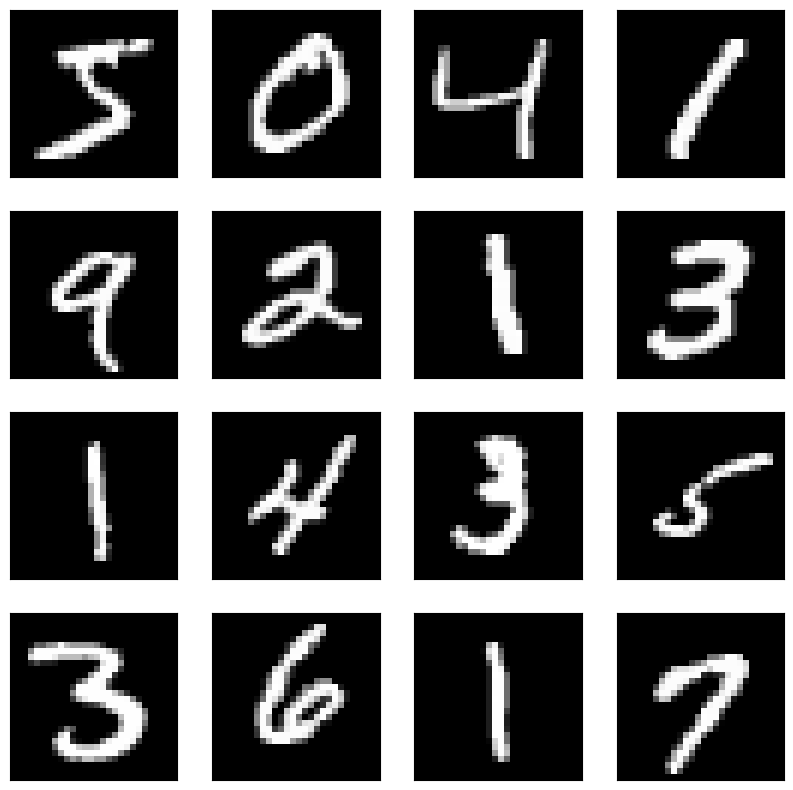

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'

def show_batch(batch_of_images):
    imgs = [img for img in batch_of_images]
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    ncols = int(np.ceil(np.sqrt(len(imgs))))
    nrows = ncols
    fig, axs = plt.subplots(ncols=ncols, nrows=ncols, squeeze=False)
    fig.set_size_inches(10, 10)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[i // ncols, np.mod(i,ncols)].imshow(np.asarray(img).squeeze(), cmap='gray')
        axs[i // ncols, np.mod(i,ncols)].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
show_batch(next(iter(train_dataloader))[0])

# Define the model


In [27]:
class Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128, bias=False),
            nn.ReLU(),
            nn.Linear(128, 128, bias=False),
            nn.ReLU(),
            nn.Linear(128, 128, bias=False),
            nn.ReLU(),
            nn.Linear(128, 128, bias=False),
            nn.ReLU(),
            nn.Linear(128, 28*28, bias=False)
            )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x
    
denoiser = Denoiser().to(device)
print(denoiser)

Denoiser(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=False)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=False)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=False)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=False)
  )
)


In [ ]:
loss = nn.MSELoss()
optimizer = torch.optim.adamw(denoiser.parameters(), lr=1e-3)

## Define training and testing loops 


In [28]:
from torch.utils.tensorboard import SummaryWriter

def add_gaussian_noise(img, mean=0, std=0.1):
    noise = torch.randn(img.size()) * std + mean
    noisy_img = img + noise
    return noisy_img

# Define training loop 
def train(model, train_dataloader, loss, optimizer):
    size = len(train_dataloader.dataset)
    model.train()
    for batch, (X, _) in enumerate(train_dataloader):
        X = X.to(device)
        noisy_X = add_gaussian_noise(X)  # noisy sample, 
        pred = model(noisy_X)  # denoised sample
        loss = loss(pred, X)   # MSE loss between denoised and original
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        # To-Do:
        # Add tensorboard loss logging and images logging
        
        
# We will check the model's performance against the test dataset to ensure it is learning 
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0 
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}, Avg loss: {test_loss:>8f} \n")
    